In [17]:
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendSampler
from qiskit_ibm_runtime import SamplerV2 as Sampler

from qiskit.visualization import plot_circuit_layout
from qiskit_ibm_runtime import QiskitRuntimeService
import qiskit_aer
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister

import numpy as np
from matplotlib import pyplot as plt

# Functions

In [60]:
def split_quasi_dist(qubit_subgroups, quasi_dist):
    """
    Split bitstrings in quasidistribution "quasi_dist" obtained from an IBM quantum computer to multiple quasidistribution for subgroups of smaller number of qubits provided by qubit_subgroups.
    The function allows to postproccess result for a request to real IBM device to run multiple small circuits in parallel.

    Parameters:
    - qubit_subgroups (list of lists): Each sublist contains the indices of qubits in the subgroup.
    - quasi_dist (dict): The results dictionary obtained from request to IBM device, with bitstrings as keys and shot counts as values.

    Returns:
    - List[dict]: A list of dictionaries, similar to imput "quasi_dist", each representing the results for a qubit subgroup.
    """
    # Initialize a list of dictionaries to hold the results for each subgroup
    subgroup_quasi_dist = [{} for _ in qubit_subgroups]

    # Iterate over each result in the original results dictionary
    for bitstring, count in quasi_dist.items():
        # For each subgroup, extract the relevant bits and add the count
        for i, subgroup in enumerate(qubit_subgroups):
            # Extract the bits relevant to the current subgroup
            subgroup_bitstring = ''.join(bitstring[index] for index in subgroup)
            # Add the count to the corresponding bitstring in the subgroup's results
            if subgroup_bitstring in subgroup_quasi_dist[i]:
                subgroup_quasi_dist[i][subgroup_bitstring] += count
            else:
                subgroup_quasi_dist[i][subgroup_bitstring] = count

    return subgroup_quasi_dist

import mthree
def mesurement_error_mitigation(qubit_subgroup, quasi_dist, backend):
    '''
    Measurement error mitigation rutine. Apply error mitigation to quasidistribution "quasi_dist" based of a noise model in "backend" corresponding to qubits in "qubit_subgroup".
    '''
    mit = mthree.M3Mitigation(backend)
    mit.cals_from_system(qubit_subgroup)
    
    quasis = mit.apply_correction(quasi_dist, qubit_subgroup, return_mitigation_overhead=True)
    quasis = quasis.nearest_probability_distribution()
    return quasis


from qiskit.result import QuasiDistribution
def quasidist_bits_to_array(quasi_dist, N_qubits):
    '''
    Convert the quasidistribution disctionary to a 2^N_qubits probabilies vector, 
    sorting and filling the missing entries.
    '''
    quasi_dist = QuasiDistribution(quasi_dist)
    
    probs_array = np.zeros(2**N_qubits)
    inds = np.array(list(quasi_dist.keys()))
    vals = np.array(list(quasi_dist.values()))
    probs_array[inds] = vals
    probs_array/=np.sum(probs_array)
    return probs_array

def sum_distributions(distributions):
    """
    Sums multiple quantum state probability distributions into a single distribution.
    
    Parameters:
    - distributions (list of dict): A list where each element is a dictionary representing
                                    a quantum state probability distribution.
    
    Returns:
    - dict: A single dictionary representing the summed probability distribution.
    """
    # Initialize an empty dictionary for the summed distribution
    summed_distribution = {}

    n = len(distributions)
    
    # Iterate over each distribution in the list
    for distribution in distributions:
        # Iterate over each quantum state and its probability in the current distribution
        for state, probability in distribution.items():
            # Normalise
            probability/=n
            # If the quantum state is already in the summed distribution, add the probability
            if state in summed_distribution:
                summed_distribution[state] += probability
            # Otherwise, add the state and probability to the summed distribution
            else:
                summed_distribution[state] = probability
                
    return summed_distribution

from copy import deepcopy
def conts_to_quasiprob_dist(conts_dist):
    '''
    Converts count distribution to quasi-tpobability distribution
    '''
    conts_dist = deepcopy(conts_dist)
    
    N_shots = sum(conts_dist.values())
    for key in conts_dist.keys():
        conts_dist[key] /= N_shots
        
    return conts_dist

# Setup IonQ simulators

In [27]:
from qiskit_ionq import IonQProvider
from qiskit_ionq.constants import ErrorMitigation

provider = IonQProvider("<MY_IBM_QUANTUM_TOKEN>")


# Ideal backend
backend_IonQ_ideal = provider.get_backend("ionq_simulator"
                                          # , gateset="native"
                                         )

# Noisy backend
backend_IonQ_noisy = provider.get_backend("ionq_simulator"
                                          # , gateset="native"
                                         )
backend_IonQ_noisy.set_options(noise_model="harmony", error_mitigation=ErrorMitigation.NO_DEBIASING)

# Create circuit to run

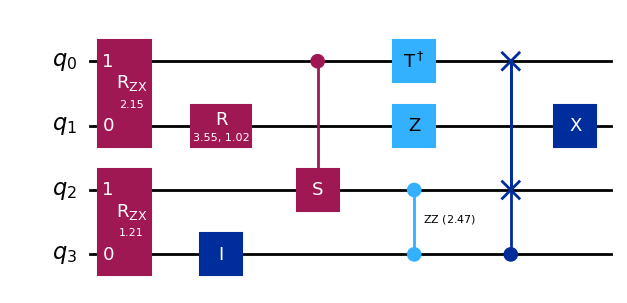

In [5]:
from qiskit.circuit.random import random_circuit

# Generate rundom circuit
N_qubits = 4
N_layers = 4
circuit = random_circuit(N_qubits, N_layers)
circuit.draw(output='mpl')

In [35]:
# Subgroups to encode the circuit instances in parallel. There are 11 qubits in totat. Here we choose the following ones:
qubit_subgroups = [
 [  1,   2,   3,   4],
 [  6,   7,   8,   9]
]
qubit_inds = np.ravel(qubit_subgroups)
N_circuits = len(qubit_subgroups)
N_qubits_tot = len(qubit_inds)

In [36]:
# Combine instances of circuits to one large circuit

# Number of classical bits
N_c_bits = np.max(qubit_subgroups)+1
full_circ = QuantumCircuit(N_qubits_tot, N_c_bits)

# Stack circuits
for i in range(N_circuits):
    full_circ.append(circuit, range(i*N_qubits,(i+1)*N_qubits))

# Fit into QPU with optimisation of the circuit
t_qc = transpile(
  full_circ,
  backend_IonQ_ideal,
  initial_layout=qubit_inds,
  optimization_level=3,
)

# Measure qubits outputs to cbits at specific locations to be able to interprete the result
for qubit_subgroup in qubit_subgroups:
    t_qc.measure(qubit_subgroup, (N_c_bits - qubit_subgroup - 1)[::-1])

/Users/viacheslavkuzman/Coding/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/viacheslavkuzman/Coding/miniconda3/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


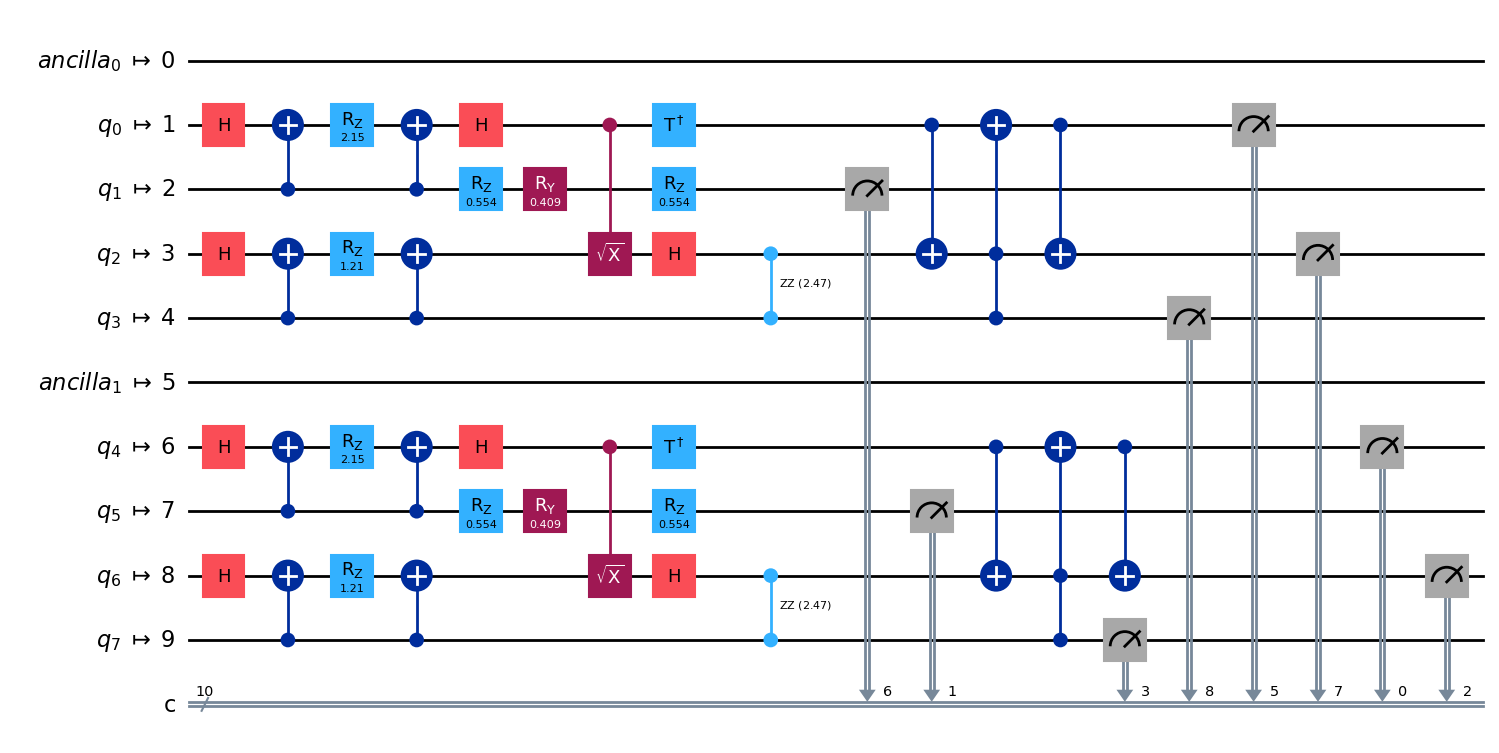

In [37]:
# This is our circuit
t_qc.draw("mpl",fold = 1000000)

# Running and analysing the result

In [86]:
# Full quasidistribution of shots for the subbmitted compiled cirquit
conts_dist = backend_IonQ_noisy.run(t_qc, shots = 1000).result().get_counts()
quasi_dist = conts_to_quasiprob_dist(conts_dist)
quasi_dist

{'0000000000': 0.015,
 '0000100000': 0.032,
 '0001000000': 0.001,
 '0001100000': 0.003,
 '0010000000': 0.009,
 '0010100000': 0.02,
 '0011000000': 0.001,
 '0011100000': 0.001,
 '0100000000': 0.004,
 '0100100000': 0.004,
 '0101100000': 0.001,
 '0110000000': 0.007,
 '0110100000': 0.007,
 '0000000001': 0.039,
 '0000100001': 0.092,
 '0001000001': 0.005,
 '0001100001': 0.008,
 '0010000001': 0.031,
 '0010100001': 0.06,
 '0011000001': 0.006,
 '0011100001': 0.007,
 '0100000001': 0.008,
 '0100100001': 0.018,
 '0101100001': 0.003,
 '0110000001': 0.015,
 '0110100001': 0.017,
 '0111000001': 0.002,
 '0111100001': 0.003,
 '0000000010': 0.003,
 '0010100010': 0.003,
 '0100100010': 0.001,
 '0110000010': 0.001,
 '0000000011': 0.003,
 '0000100011': 0.008,
 '0010000011': 0.002,
 '0010100011': 0.003,
 '0110000011': 0.004,
 '0110100011': 0.002,
 '0000000100': 0.01,
 '0000100100': 0.035,
 '0001000100': 0.001,
 '0001100100': 0.003,
 '0010000100': 0.01,
 '0010100100': 0.011,
 '0011100100': 0.002,
 '0100000100':

In [80]:
# Full quasidistribution of shots for the subbmitted compiled cirquit
conts_dist = backend_IonQ_noisy.run(t_qc, shots = 1000).result().get_counts()
quasi_dist = conts_to_quasiprob_dist(conts_dist)
quasi_dist

{'0000000000': 0.014,
 '0000100000': 0.04,
 '0001000000': 0.002,
 '0001100000': 0.004,
 '0010000000': 0.012,
 '0010100000': 0.01,
 '0011000000': 0.002,
 '0011100000': 0.002,
 '0100000000': 0.006,
 '0100100000': 0.006,
 '0101100000': 0.001,
 '0110000000': 0.008,
 '0110100000': 0.006,
 '0000000001': 0.032,
 '0000100001': 0.091,
 '0001000001': 0.005,
 '0001100001': 0.012,
 '0010000001': 0.021,
 '0010100001': 0.06,
 '0011000001': 0.001,
 '0011100001': 0.006,
 '0100000001': 0.006,
 '0100100001': 0.018,
 '0101100001': 0.002,
 '0110000001': 0.017,
 '0110100001': 0.02,
 '0111000001': 0.002,
 '0000000010': 0.002,
 '0000100010': 0.003,
 '0001000010': 0.001,
 '0010100010': 0.003,
 '0100000010': 0.001,
 '0110000010': 0.001,
 '0110100010': 0.002,
 '0000000011': 0.003,
 '0000100011': 0.008,
 '0001000011': 0.001,
 '0001100011': 0.001,
 '0010000011': 0.003,
 '0010100011': 0.007,
 '0100100011': 0.005,
 '0000000100': 0.011,
 '0000100100': 0.036,
 '0001000100': 0.002,
 '0001100100': 0.004,
 '0010000100':

In [87]:
# Split the distribution to subgroups corresponding to each separate circuit 
subgroup_quasi_dists = split_quasi_dist(qubit_subgroups, quasi_dist)
subgroup_quasi_dists

[{'0000': 0.11000000000000001,
  '0001': 0.31300000000000006,
  '0010': 0.012,
  '0011': 0.028000000000000004,
  '0100': 0.10000000000000002,
  '0101': 0.18500000000000003,
  '0110': 0.010000000000000002,
  '0111': 0.027,
  '1000': 0.029,
  '1001': 0.059000000000000004,
  '1011': 0.007,
  '1100': 0.05600000000000001,
  '1101': 0.05400000000000001,
  '1110': 0.004,
  '1111': 0.004,
  '1010': 0.002},
 {'0000': 0.10500000000000002,
  '0001': 0.31400000000000006,
  '0010': 0.008,
  '0011': 0.022,
  '0100': 0.09600000000000003,
  '0101': 0.24700000000000005,
  '0110': 0.010000000000000002,
  '0111': 0.014000000000000002,
  '1000': 0.030000000000000002,
  '1001': 0.036000000000000004,
  '1010': 0.002,
  '1011': 0.006,
  '1100': 0.052000000000000005,
  '1101': 0.05100000000000001,
  '1110': 0.004,
  '1111': 0.003}]

In [88]:
# Convert to probabilities vectors
subgroup_prob_dists = [quasidist_bits_to_array(s, N_qubits) for s in subgroup_quasi_dists]

In [89]:
subgroup_prob_dists

[array([0.11 , 0.313, 0.012, 0.028, 0.1  , 0.185, 0.01 , 0.027, 0.029,
        0.059, 0.002, 0.007, 0.056, 0.054, 0.004, 0.004]),
 array([0.105, 0.314, 0.008, 0.022, 0.096, 0.247, 0.01 , 0.014, 0.03 ,
        0.036, 0.002, 0.006, 0.052, 0.051, 0.004, 0.003])]

In [90]:
# Sum all distributions for averaging. This is done here since all the submitted are the same so we can just accumulate the shots faster. But in principle you can just submit different circuits.
quasi_dists_sum = sum_distributions(subgroup_quasi_dists)
prob_dists_sum = quasidist_bits_to_array(quasi_dists_sum, N_qubits)

In [91]:
prob_dists_sum

array([0.1075, 0.3135, 0.01  , 0.025 , 0.098 , 0.216 , 0.01  , 0.0205,
       0.0295, 0.0475, 0.002 , 0.0065, 0.054 , 0.0525, 0.004 , 0.0035])

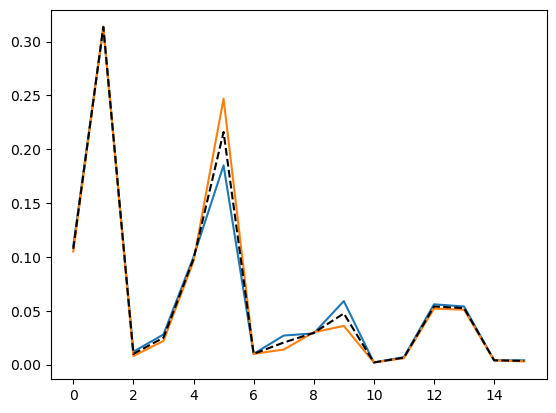

In [92]:
# See that all distributions from differen qubit groups are in fact simmilar and compare to the resulting avaraged one.
for s in subgroup_prob_dists:
    plt.plot(s)

plt.plot(prob_dists_sum, 'k--')

# Observables from the measurements

In [96]:
# Here we also can use the obtained avaraged distribution to obtain observables which you can use as e.g. as a loss.
quasi_dists_av = mthree.classes.ProbDistribution(quasi_dists_sum)

observables = []
for i in range(N_qubits):
    obsev = ['i']*N_qubits
    obsev[i] = 'z'
    observables += [''.join(obsev)]

[quasi_dists_av.expval(observ) for observ in observables]

[0.6010000000000001, 0.08300000000000002, 0.8370000000000001, -0.37]